In [1]:
! pip install opendatasets

In [2]:
import opendatasets as od
import numpy as np
import random

In [3]:
od.download('https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: farouqanbar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset


100%|██████████| 1.06G/1.06G [00:08<00:00, 138MB/s]


In [4]:
X = np.load('27-class-sign-language-dataset/X.npy')
y = np.load('27-class-sign-language-dataset/Y.npy')

In [5]:
print(f"Original shapes: X: {X.shape}, y: {y.shape}")

Original shapes: X: (22801, 128, 128, 3), y: (22801, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [7]:
label_encoder = LabelEncoder()

y_selected_ravel = y.ravel()

y_encoded = label_encoder.fit_transform(y_selected_ravel)  # Convert strings to integers
num_classes = len(label_encoder.classes_)  # Number of unique classes
y_categorical = to_categorical(y_encoded, num_classes=num_classes)  # One-hot encode

In [8]:
# Step 4: Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(1000)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# Model 01: Vanilla CNN

In [9]:
from tensorflow.keras.utils import plot_model

In [10]:
# Step 6: Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer matches num_classes
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

In [13]:
!pip install pydot

In [14]:
plot_model(model,
           show_shapes = True,
           dpi = 100)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
# Step 8: Train the model
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

# Step 9: Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Optional: Map predictions back to string labels
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

Epoch 1/5
570/570 [==============================] - 412s 716ms/step - loss: 2.4366 - accuracy: 0.2964 - val_loss: 1.5013 - val_accuracy: 0.5412
Epoch 2/5
570/570 [==============================] - 405s 706ms/step - loss: 1.0629 - accuracy: 0.6832 - val_loss: 1.0658 - val_accuracy: 0.6728
Epoch 3/5
570/570 [==============================] - 400s 700ms/step - loss: 0.5048 - accuracy: 0.8465 - val_loss: 0.9978 - val_accuracy: 0.6996
Epoch 4/5
570/570 [==============================] - 406s 709ms/step - loss: 0.1931 - accuracy: 0.9413 - val_loss: 1.2532 - val_accuracy: 0.7066
Epoch 5/5
72/72 [==============================] - 13s 176ms/step - loss: 1.4646 - accuracy: 0.7291
Test Accuracy: 0.7290661931037903
72/72 [==============================] - 12s 168ms/step


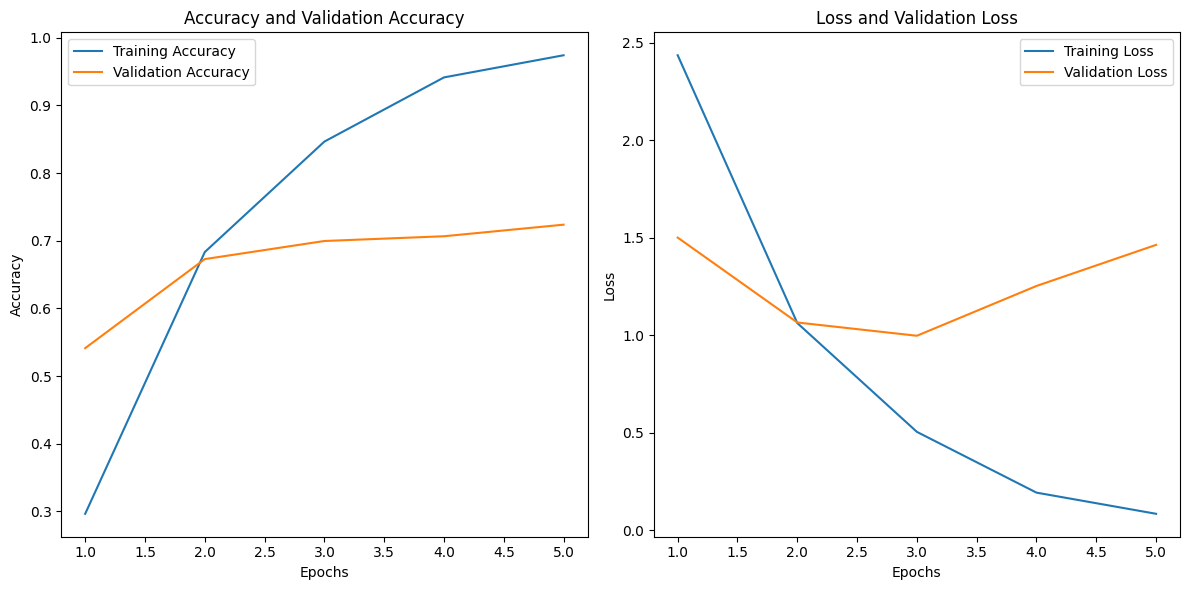

In [26]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the number of epochs
epochs = range(1, len(acc) + 1)

# Plot accuracy and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model 02: ResNet

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Input, Rescaling, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2

In [21]:
pretrained_model = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top = False,
    input_shape = (128, 128, 3)
)

94668760/94668760 [==============================] - 0s 0us/step


In [22]:
pretrained_model.trainable = False

In [23]:
IMG_SIZE = (128, 128)

i = Input(shape = IMG_SIZE + (3,))
x = pretrained_model(i)
print(f'Shape after passing inputs through base model: {x.shape}')
x = GlobalAveragePooling2D()(x)
print(f'Shape after passing inputs through global average pooling: {x.shape}')
o = Dense(num_classes, activation = 'softmax')(x)

m0 = Model(i, o)

Shape after passing inputs through base model: (None, 4, 4, 2048)
Shape after passing inputs through global average pooling: (None, 2048)


In [ ]:
pretrained_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 32, 32, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 32, 32, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 34, 34, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
plot_model(pretrained_model,
           show_shapes = True,
           dpi = 100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
m0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 4, 4, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 27)                  │          55,323 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,620,123 (90.10 MB)

 Trainable params: 55,323 (216.11 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

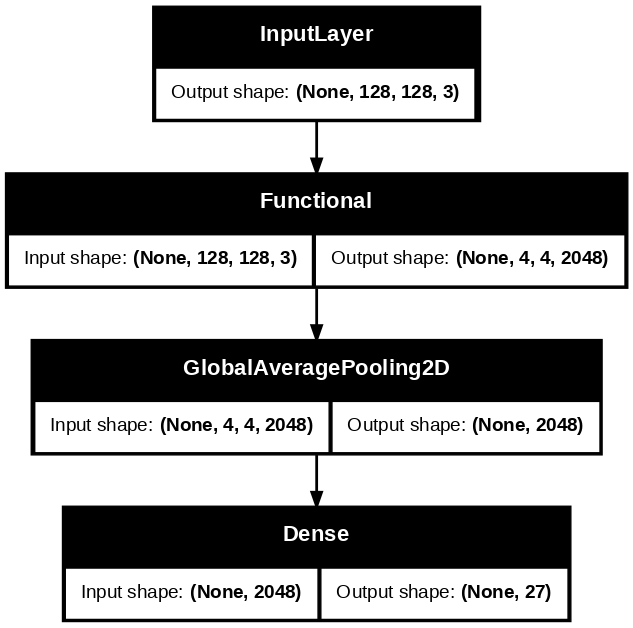

In [ ]:
plot_model(m0,
           show_shapes = True,
           dpi = 100)

In [27]:
m0.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)
r0 = m0.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
570/570 [==============================] - 1355s 2s/step - loss: 1.3282 - accuracy: 0.5827 - val_loss: 1.0287 - val_accuracy: 0.6689
Epoch 2/5
570/570 [==============================] - 1345s 2s/step - loss: 0.7590 - accuracy: 0.7529 - val_loss: 0.8843 - val_accuracy: 0.7044
Epoch 3/5
570/570 [==============================] - 1354s 2s/step - loss: 0.5726 - accuracy: 0.8164 - val_loss: 0.7798 - val_accuracy: 0.7417
Epoch 4/5
570/570 [==============================] - 1358s 2s/step - loss: 0.4611 - accuracy: 0.8526 - val_loss: 0.7560 - val_accuracy: 0.7509
Epoch 5/5
570/570 [==============================] - 1349s 2s/step - loss: 0.3904 - accuracy: 0.8761 - val_loss: 0.7497 - val_accuracy: 0.7601


In [28]:
# Step 9: Evaluate the model
test_loss, test_acc = m0.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Optional: Map predictions back to string labels
predictions = m0.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

72/72 [==============================] - 151s 2s/step - loss: 0.7663 - accuracy: 0.7562
Test Accuracy: 0.7562472820281982
72/72 [==============================] - 151s 2s/step


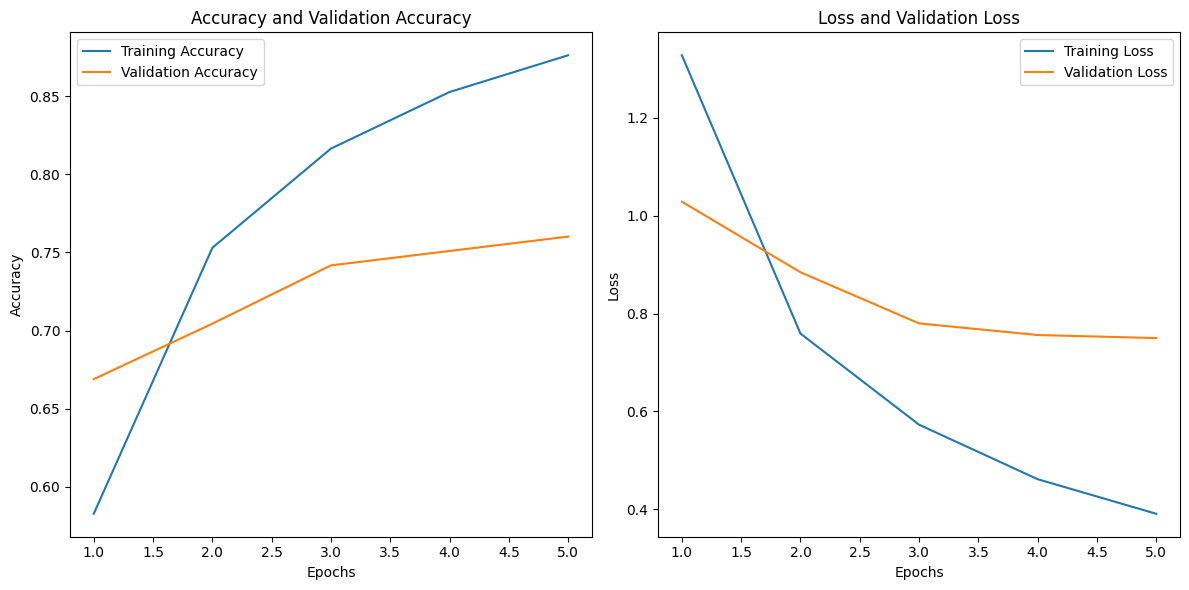

In [29]:
# Extract metrics from the history object
acc = r0.history['accuracy']
val_acc = r0.history['val_accuracy']
loss = r0.history['loss']
val_loss = r0.history['val_loss']

# Extract the number of epochs
epochs = range(1, len(acc) + 1)

# Plot accuracy and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model 03: CNN with RF

In [31]:
# Step 6: Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer matches num_classes
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Train the model
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
570/570 [==============================] - 409s 712ms/step - loss: 2.5115 - accuracy: 0.2657 - val_loss: 1.3949 - val_accuracy: 0.5583
Epoch 2/5
570/570 [==============================] - 397s 692ms/step - loss: 1.0081 - accuracy: 0.6907 - val_loss: 0.8934 - val_accuracy: 0.7307
Epoch 3/5
570/570 [==============================] - 396s 693ms/step - loss: 0.4994 - accuracy: 0.8435 - val_loss: 0.7726 - val_accuracy: 0.7592
Epoch 4/5
570/570 [==============================] - 395s 692ms/step - loss: 0.2346 - accuracy: 0.9268 - val_loss: 1.0036 - val_accuracy: 0.7548
Epoch 5/5
570/570 [==============================] - 387s 678ms/step - loss: 0.1341 - accuracy: 0.9582 - val_loss: 1.0231 - val_accuracy: 0.7482


In [32]:
import numpy as np
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assume 'cnn_model' is your trained CNN model
# Remove the final dense layer and create a feature extractor
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features from training data
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Flatten features if necessary
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Train a Random Forest classifier on the extracted features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_features)

# Evaluate the Random Forest model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")


72/72 [==============================] - 12s 163ms/step
Random Forest Accuracy: 0.54


# Model 04: ResNet with RF

In [ ]:
# Assume 'cnn_model' is your trained CNN model
# Remove the final dense layer and create a feature extractor
feature_extractor = Model(inputs=m0.input, outputs=m0.layers[-2].output)

# Extract features from training data
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Flatten features if necessary
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Train a Random Forest classifier on the extracted features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_features)

# Evaluate the Random Forest model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
